
# Seattle Fremont Bridge bike count data

Here again, is how we downloaded the bike data, but using a jupyter notebook instead of a python script executed by bash script in the Unix shell.

    Either re-download here, or edit path to where you saved it yesterday

Download data from here: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

Right click on 'CSV' and copy link location


In [1]:
# Version 2: Downloading the data
# In this function, we write a function with conditional statements
# to decide whether the file exists or not before downloading the data
# We'll also add dataframe formatting to the function, so that the returned data
# is ready to be analyzed
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
#%%timeit

from pypackage_scripts.data import get_fremont_data

data = get_fremont_data()

In [13]:
data.head()

,East,West,Total
Date,,,
2012-10-03 00:00:00,9.0,4.0,13.0
2012-10-03 01:00:00,6.0,4.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,3.0,2.0,5.0
2012-10-03 04:00:00,1.0,6.0,7.0


In [14]:
data.shape

(52536, 3)

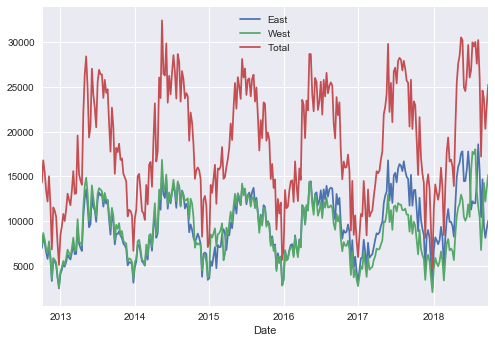

In [4]:
data.resample('W').sum().plot()

(0, 1080850.45)

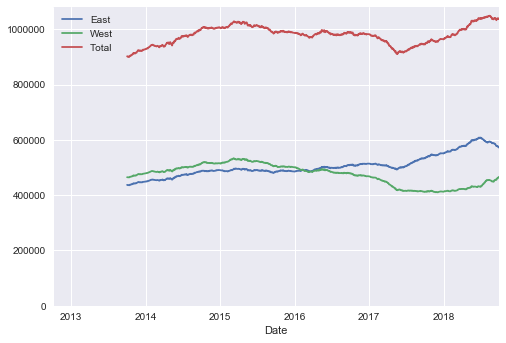

In [5]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

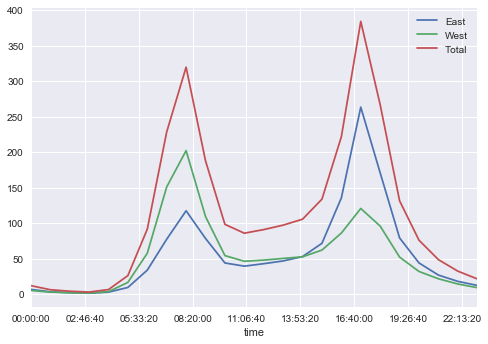

In [6]:
data.groupby(data.index.time).mean().plot()

In [7]:
pivoted = data.pivot_table('Total', index = data.index.time, columns = data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


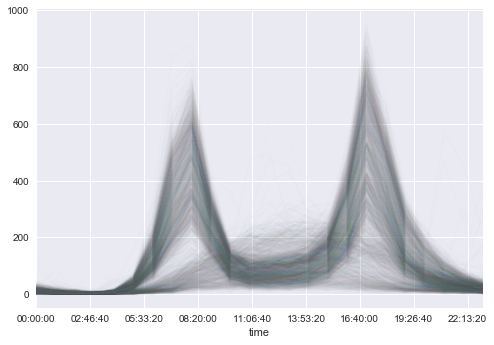

In [8]:
pivoted.plot(legend=False, alpha=0.01)

In [10]:
pivoted.shape #(hours, days)

(24, 2189)

In [15]:
pivoted.T.shape #transpose (days, hours)

(2189, 24)

In [16]:
from sklearn.decomposition import PCA
PCA(2) 

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
X = pivoted.fillna(0).T.values

In [19]:
X2 = PCA(2).fit_transform(X)

In [20]:
X2.shape

(2189, 2)

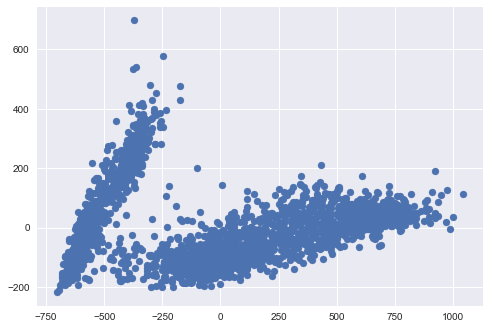

In [21]:
plt.scatter(X2[:,0], X2[:,1])

In [49]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2) # 2 clusters
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

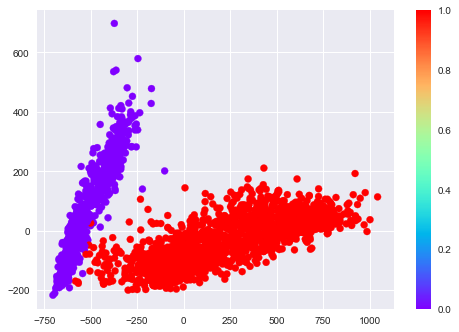

In [50]:
labels = gmm.predict(X)
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='rainbow')
plt.colorbar()

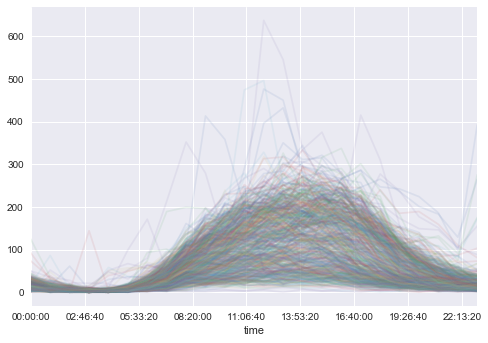

In [51]:
# this is the weekender-like data
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1)

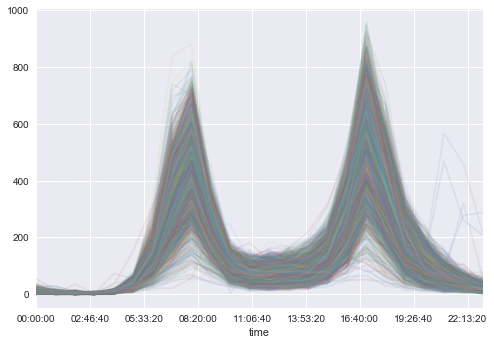

In [52]:
# this looks like the weekday-ish data
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1)
# visually, we thought there were 2 clusters
# looks right! but we have yet to confirm exactly what the different groups are

In [53]:
pd.DatetimeIndex(pivoted.columns).dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
           dtype='int64', length=2189)

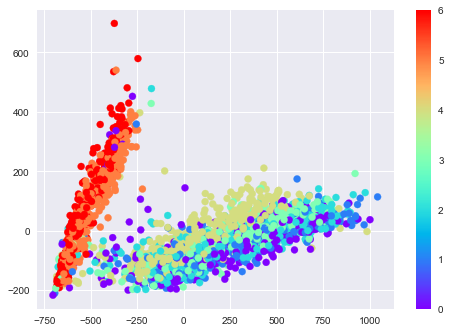

In [54]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek
plt.scatter(X2[:,0], X2[:,1], c=dayofweek, cmap='rainbow')
plt.colorbar()
# now we can see that one cluster has Sun/Sat and the other weekdays
# those it's not perfect

In [55]:
# let's look at the outliers
dates = pd.DatetimeIndex(pivoted.columns)

# note that Gaussian mixture models are probabilistic so if you re-run this, the 0's and 1's columns may switch
# so you might have to change the label from 0 or 1 to choose the weekend-like cluster outliers
dates[(labels == 0) & (dayofweek < 5)] 
# these look mostly like holidays
# also Feb 6 2017 was a major snow event that canceled work for people!

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-11-23', '2017-11-24', '2017-12-25', '2017-12-26',
               '2018-01-01', '2018-05-28', '2018-07-04', '2018-09-03'],
              dtype='datetime64[ns]', freq=None)

Text(0.5,1,'Red cluster')

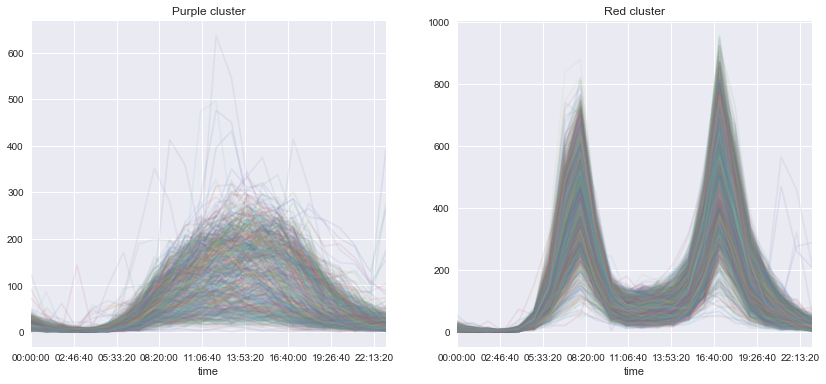

In [60]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0])
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1])

ax[0].set_title('Purple cluster')
ax[1].set_title('Red cluster')